# Gr√°ficos de Cleveland: CT Filtrados Cruzados por Categor√≠a Ideol√≥gica

Este notebook genera **gr√°ficos de Cleveland** para visualizar el Cambio de Tiempo Filtrado (CT_Filtrado) comparando candidatos de **Izquierda** vs **Derecha**, cruzado con tipo de √≠tem (Progresista/Conservador), agrupado por **categor√≠a ideol√≥gica**.

## Concepto:

### CT Filtrado Cruzado:
- **Pro_Izq**: √çtems Progresistas √ó Candidatos de Izquierda (suma de √≠tems significativos)
- **Pro_Der**: √çtems Progresistas √ó Candidatos de Derecha
- **Con_Izq**: √çtems Conservadores √ó Candidatos de Izquierda
- **Con_Der**: √çtems Conservadores √ó Candidatos de Derecha

### Visualizaci√≥n:
- **Panel A**: √çtems Progresistas (Pro_Izq vs Pro_Der)
- **Panel B**: √çtems Conservadores (Con_Izq vs Con_Der)
- **Eje Y**: 6 categor√≠as ideol√≥gicas
- **Punto azul (‚óè)**: Candidatos de Izquierda
- **Punto rojo (‚óè)**: Candidatos de Derecha

## Interpretaci√≥n:

- **Valores m√°s negativos**: Mayor cambio de tiempo (m√°s lento)
- **Hip√≥tesis**: Mayor tiempo en contenido ideol√≥gicamente af√≠n

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.lines import Line2D
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('‚úì Librer√≠as cargadas exitosamente')

‚úì Librer√≠as cargadas exitosamente


## 1. Cargar Datos

In [2]:
# Rutas a los archivos
Ruta_Base = os.path.join(os.getcwd(), '..', 'Data', 'Bases definitivas')
Archivo_Generales = os.path.join(Ruta_Base, 'Generales.xlsx')
Archivo_Ballotage = os.path.join(Ruta_Base, 'Ballotage.xlsx')

# Cargar datos
df_Generales = pd.read_excel(Archivo_Generales)
df_Ballotage = pd.read_excel(Archivo_Ballotage)

dfs = {
    'Generales': df_Generales,
    'Ballotage': df_Ballotage
}

print(f'‚úì Datos cargados:')
print(f'  - Generales: {len(df_Generales)} registros')
print(f'  - Ballotage: {len(df_Ballotage)} registros')

# Verificar variables CT_Filtrado
vars_ct_filt = [
    'Cambio_Tiempo_Filt_Pro_Izq',
    'Cambio_Tiempo_Filt_Pro_Der',
    'Cambio_Tiempo_Filt_Con_Izq',
    'Cambio_Tiempo_Filt_Con_Der'
]

for nombre, df in dfs.items():
    faltantes = [v for v in vars_ct_filt if v not in df.columns]
    if faltantes:
        print(f'  ‚ö†Ô∏è  {nombre}: Faltan variables {faltantes}')
    else:
        print(f'  ‚úÖ {nombre}: Todas las variables CT_Filtrado presentes')

‚úì Datos cargados:
  - Generales: 2786 registros
  - Ballotage: 1254 registros
  ‚úÖ Generales: Todas las variables CT_Filtrado presentes
  ‚úÖ Ballotage: Todas las variables CT_Filtrado presentes


## 2. Preparar Datos para Gr√°fico

In [3]:
# Definir categor√≠as ideol√≥gicas
Categorias = [
    'Left_Wing',
    'Progressivism',
    'Centre',
    'Moderate_Right_A',
    'Moderate_Right_B',
    'Right_Wing_Libertarian'
]

Etiquetas_Categorias = {
    'Left_Wing': 'Left Wing',
    'Progressivism': 'Progressivism',
    'Centre': 'Centre',
    'Moderate_Right_A': 'Moderate Right A',
    'Moderate_Right_B': 'Moderate Right B',
    'Right_Wing_Libertarian': 'Right Wing Libertarian'
}

print(f'Categor√≠as ideol√≥gicas: {len(Categorias)}')
for cat in Categorias:
    print(f'  - {Etiquetas_Categorias[cat]}')

Categor√≠as ideol√≥gicas: 6
  - Left Wing
  - Progressivism
  - Centre
  - Moderate Right A
  - Moderate Right B
  - Right Wing Libertarian


In [4]:
# Preparar datos por categor√≠a para cada tipo (Progresistas y Conservadores)
def Preparar_Datos_CT_Filtrado(df, categorias, var_izq, var_der, tipo_item):
    """
    Calcula promedios de CT_Filtrado por categor√≠a.
    Incluye test t pareado para significancia estad√≠stica.
    """
    datos = []
    
    for categoria in categorias:
        df_cat = df[df['Categoria_PASO_2023'] == categoria]
        
        if len(df_cat) > 0:
            media_izq = df_cat[var_izq].mean()
            media_der = df_cat[var_der].mean()
            diferencia = media_izq - media_der
            
            # Test t pareado para significancia
            datos_pareados = df_cat[[var_izq, var_der]].dropna()
            if len(datos_pareados) > 1:
                from scipy.stats import ttest_rel
                try:
                    t_stat, p_valor = ttest_rel(datos_pareados[var_izq], 
                                                datos_pareados[var_der])
                    
                    # Determinar asteriscos de significancia
                    if p_valor < 0.001:
                        sig = '***'
                    elif p_valor < 0.01:
                        sig = '**'
                    elif p_valor < 0.05:
                        sig = '*'
                    else:
                        sig = ''
                except:
                    p_valor = np.nan
                    sig = ''
            else:
                p_valor = np.nan
                sig = ''
            
            datos.append({
                'Categoria': categoria,
                'Etiqueta': Etiquetas_Categorias[categoria],
                'Tipo_Item': tipo_item,
                'n': len(df_cat),
                'CT_Izquierda': media_izq,
                'CT_Derecha': media_der,
                'Diferencia': diferencia,
                'p_valor': p_valor,
                'Significancia': sig
            })
    
    return pd.DataFrame(datos)

# Preparar datos para ambos datasets y ambos tipos
datos_graficos = {}

for nombre, df in dfs.items():
    # √çtems Progresistas
    df_prog = Preparar_Datos_CT_Filtrado(
        df, Categorias,
        'Cambio_Tiempo_Filt_Pro_Izq',
        'Cambio_Tiempo_Filt_Pro_Der',
        'Progresistas'
    )
    
    # √çtems Conservadores
    df_cons = Preparar_Datos_CT_Filtrado(
        df, Categorias,
        'Cambio_Tiempo_Filt_Con_Izq',
        'Cambio_Tiempo_Filt_Con_Der',
        'Conservadores'
    )
    
    datos_graficos[nombre] = {
        'Progresistas': df_prog,
        'Conservadores': df_cons
    }
    
    print(f'\n{nombre}:')
    print('  Progresistas:')
    print(df_prog[['Etiqueta', 'n', 'CT_Izquierda', 'CT_Derecha', 'Diferencia', 'Significancia']])
    print('\n  Conservadores:')
    print(df_cons[['Etiqueta', 'n', 'CT_Izquierda', 'CT_Derecha', 'Diferencia', 'Significancia']])


Generales:
  Progresistas:
                 Etiqueta     n  CT_Izquierda  CT_Derecha  Diferencia  \
0               Left Wing   425     -0.260002   -0.464478    0.204475   
1           Progressivism  1257     -0.800909   -1.499746    0.698837   
2                  Centre    84     -0.684667   -3.955208    3.270542   
3        Moderate Right A   208     -1.657120   -2.789264    1.132144   
4        Moderate Right B   212     -1.069182   -2.763137    1.693955   
5  Right Wing Libertarian   185     -1.668092   -4.613978    2.945886   

  Significancia  
0                
1             *  
2                
3                
4             *  
5             *  

  Conservadores:
                 Etiqueta     n  CT_Izquierda  CT_Derecha  Diferencia  \
0               Left Wing   425     -2.956982   -2.635021   -0.321961   
1           Progressivism  1257     -3.246426   -3.193776   -0.052650   
2                  Centre    84     -1.072179   -2.164905    1.092726   
3        Moderate Right 

## 3. Funci√≥n para Crear Gr√°fico Cleveland Comparativo

In [5]:
def Crear_Grafico_Cleveland_CT_Filtrado_Comparativo(df_prog, df_cons, titulo, nombre_archivo=None, carpeta_destino='Graficos_Cleveland'):
    """
    Crea gr√°fico con 2 paneles: Progresistas vs Conservadores.
    Incluye asteriscos para indicar significancia estad√≠stica.
    """
    
    # Crear carpeta si no existe
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)
    
    # Crear figura con 2 paneles
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Determinar l√≠mites comunes del eje X
    min_val = min(
        df_prog['CT_Izquierda'].min(), df_prog['CT_Derecha'].min(),
        df_cons['CT_Izquierda'].min(), df_cons['CT_Derecha'].min()
    )
    max_val = max(
        df_prog['CT_Izquierda'].max(), df_prog['CT_Derecha'].max(),
        df_cons['CT_Izquierda'].max(), df_cons['CT_Derecha'].max()
    )
    margen = (max_val - min_val) * 0.1
    
    # Funci√≥n helper para dibujar un panel
    def Dibujar_Panel(ax, df, titulo_panel, mostrar_ylabel):
        # Ordenar por diferencia
        df_sorted = df.sort_values('Diferencia', ascending=True).reset_index(drop=True)
        y_positions = np.arange(len(df_sorted))
        
        # Dibujar l√≠neas
        for idx, row in df_sorted.iterrows():
            izq_val = row['CT_Izquierda']
            der_val = row['CT_Derecha']
            diferencia = row['Diferencia']
            
            # Color seg√∫n diferencia
            if diferencia > 0.5:
                color_linea = '#3498db'  # Azul
                alpha = 0.7
            elif diferencia < -0.5:
                color_linea = '#e74c3c'  # Rojo
                alpha = 0.7
            else:
                color_linea = '#95a5a6'  # Gris
                alpha = 0.4
            
            ax.plot([der_val, izq_val], [idx, idx],
                    color=color_linea, linewidth=2, alpha=alpha, zorder=1)
        
        # Dibujar puntos
        ax.scatter(df_sorted['CT_Izquierda'], y_positions,
                   s=150, c='#3498db', marker='o',
                   edgecolors='white', linewidths=2,
                   label='Izquierda', zorder=3, alpha=0.9)
        
        ax.scatter(df_sorted['CT_Derecha'], y_positions,
                   s=150, c='#e74c3c', marker='o',
                   edgecolors='white', linewidths=2,
                   label='Derecha', zorder=3, alpha=0.9)
        
        # L√≠nea vertical en x=0
        ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.3, zorder=0)
        
        # Configurar ejes con asteriscos de significancia
        ax.set_yticks(y_positions)
        etiquetas_con_sig = [f"{row['Etiqueta']} {row['Significancia']}" if row['Significancia'] else row['Etiqueta'] 
                             for _, row in df_sorted.iterrows()]
        ax.set_yticklabels(etiquetas_con_sig, fontsize=11)
        
        ax.set_xlabel('CT Filtrado (segundos)', fontsize=12, fontweight='bold')
        if mostrar_ylabel:
            ax.set_ylabel('Categor√≠a Ideol√≥gica', fontsize=12, fontweight='bold')
        
        ax.set_title(titulo_panel, fontsize=13, fontweight='bold', pad=15)
        
        # Grid
        ax.grid(True, axis='x', alpha=0.3, linestyle=':', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Ajustar l√≠mites X
        ax.set_xlim(min_val - margen, max_val + margen)
    
    # Panel A: Progresistas
    Dibujar_Panel(ax1, df_prog, 'A) √çtems Progresistas', True)
    
    # Panel B: Conservadores
    Dibujar_Panel(ax2, df_cons, 'B) √çtems Conservadores', False)
    
    # Leyenda com√∫n
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db',
               markersize=11, label='Candidatos Izquierda', markeredgecolor='white', markeredgewidth=1.5),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c',
               markersize=11, label='Candidatos Derecha', markeredgecolor='white', markeredgewidth=1.5),
        Line2D([0], [0], color='#3498db', linewidth=2.5, label='M√°s Izq (>0.5s)'),
        Line2D([0], [0], color='#95a5a6', linewidth=2.5, label='Similar (¬±0.5s)'),
        Line2D([0], [0], color='#e74c3c', linewidth=2.5, label='M√°s Der (<-0.5s)'),
        Line2D([0], [0], marker='', color='w', label='* p<0.05, ** p<0.01, *** p<0.001')
    ]
    
    fig.legend(handles=legend_elements, loc='upper center', ncol=6,
               fontsize=11, framealpha=0.95, edgecolor='gray',
               bbox_to_anchor=(0.5, 0.98))
    
    # T√≠tulo general
    fig.suptitle(titulo, fontsize=14, fontweight='bold', y=0.995)
    
    # Ajustar layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Guardar
    if nombre_archivo:
        ruta_completa = os.path.join(carpeta_destino, f'{nombre_archivo}.svg')
        plt.savefig(ruta_completa.replace('.png', '.svg'), format='svg', bbox_inches='tight', facecolor='white')
        print(f'‚úÖ Gr√°fico guardado: {ruta_completa}')
    
    plt.show()
    
    return fig, (ax1, ax2)

## 4. Gr√°ficos por Dataset

Generando gr√°fico para Generales...

‚úÖ Gr√°fico guardado: Graficos_Cleveland\Cleveland_CT_Filtrado_Cruzado_Generales.png


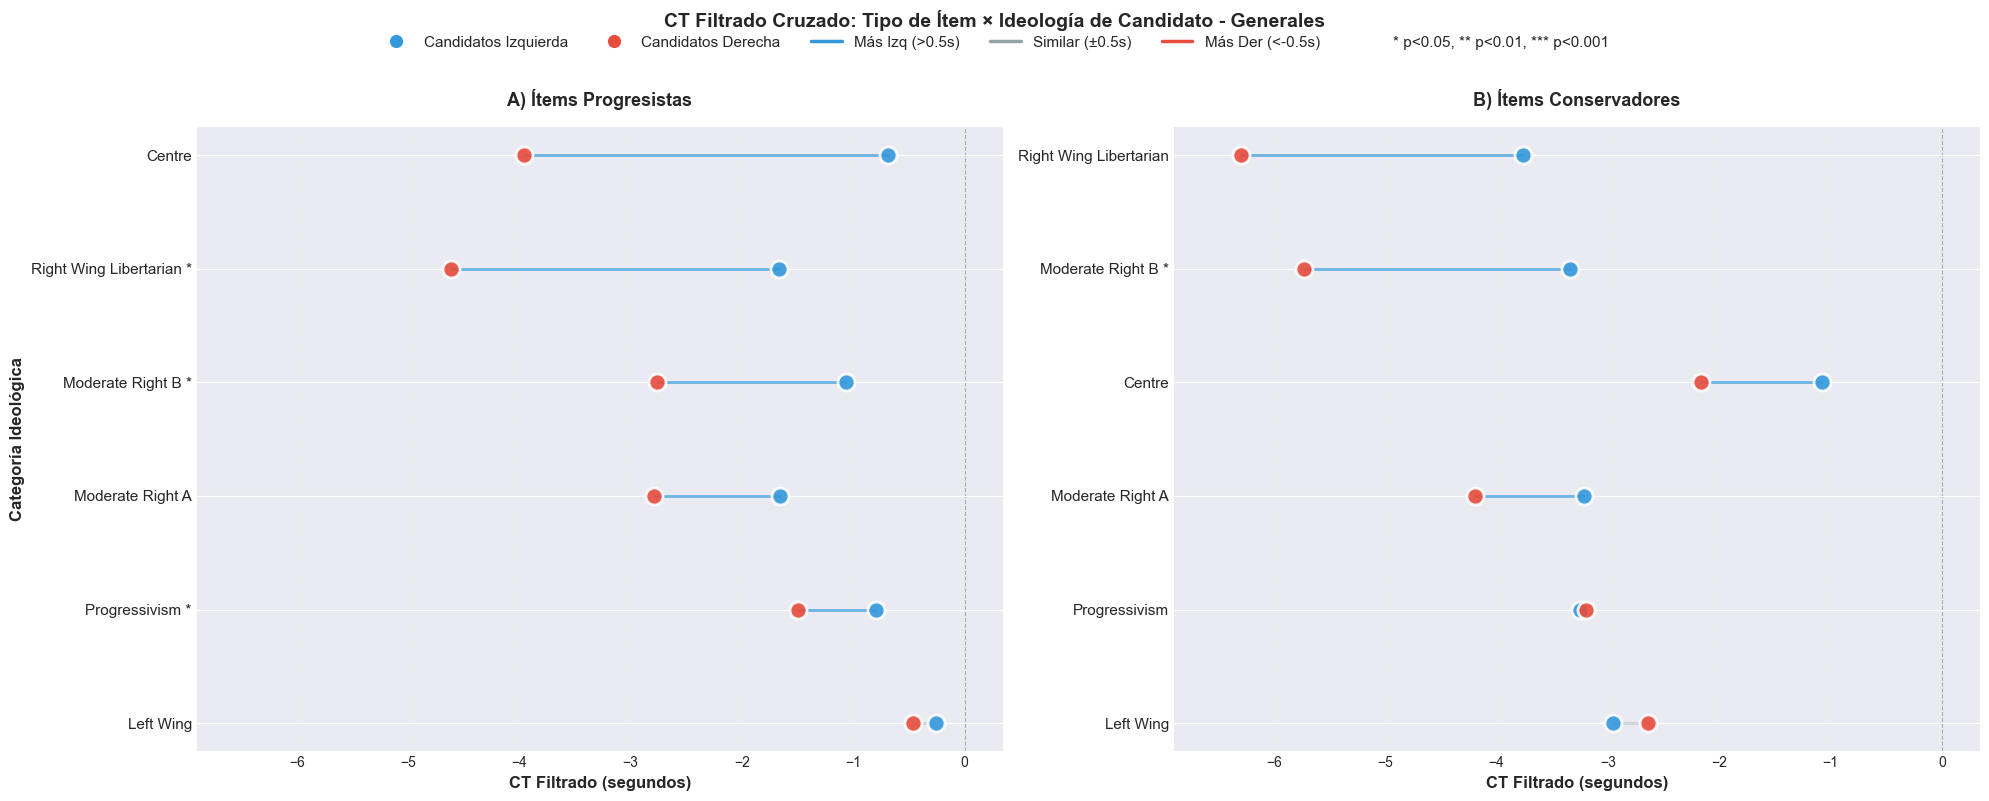

In [6]:
# Gr√°fico para Generales
print('Generando gr√°fico para Generales...\n')
fig_gen, (ax1_gen, ax2_gen) = Crear_Grafico_Cleveland_CT_Filtrado_Comparativo(
    datos_graficos['Generales']['Progresistas'],
    datos_graficos['Generales']['Conservadores'],
    titulo='CT Filtrado Cruzado: Tipo de √çtem √ó Ideolog√≠a de Candidato - Generales',
    nombre_archivo='Cleveland_CT_Filtrado_Cruzado_Generales'
)

Generando gr√°fico para Ballotage...

‚úÖ Gr√°fico guardado: Graficos_Cleveland\Cleveland_CT_Filtrado_Cruzado_Ballotage.png


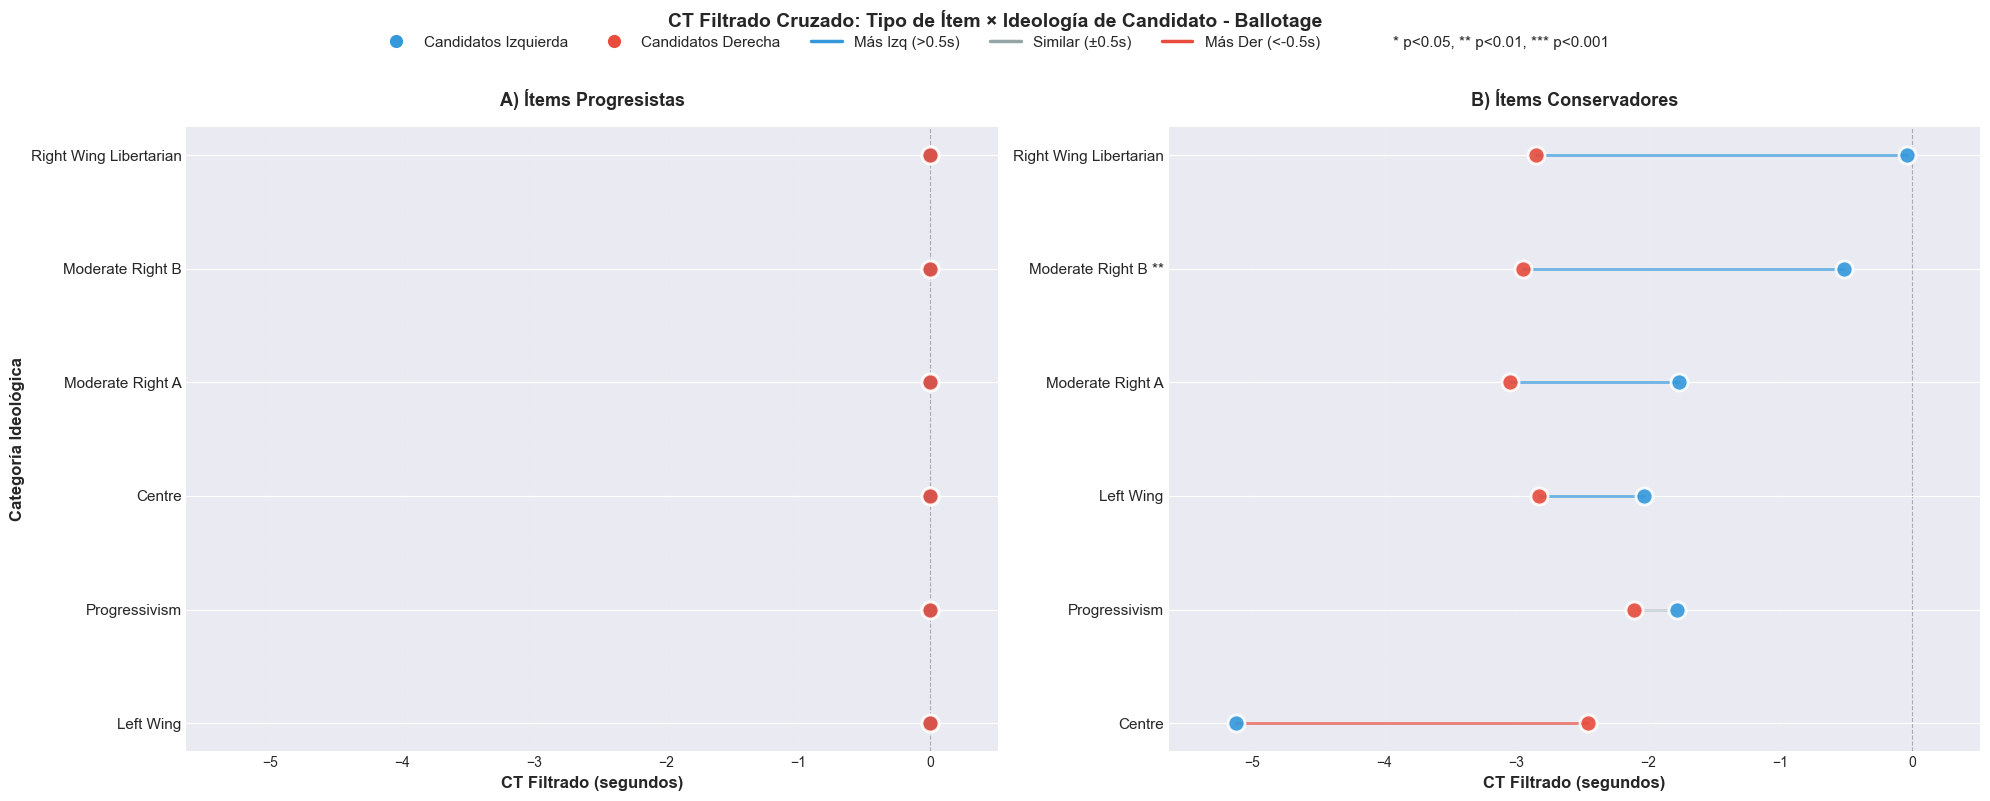

In [7]:
# Gr√°fico para Ballotage
print('Generando gr√°fico para Ballotage...\n')
fig_bal, (ax1_bal, ax2_bal) = Crear_Grafico_Cleveland_CT_Filtrado_Comparativo(
    datos_graficos['Ballotage']['Progresistas'],
    datos_graficos['Ballotage']['Conservadores'],
    titulo='CT Filtrado Cruzado: Tipo de √çtem √ó Ideolog√≠a de Candidato - Ballotage',
    nombre_archivo='Cleveland_CT_Filtrado_Cruzado_Ballotage'
)

## 4.1. An√°lisis de Significancia Estad√≠stica

In [8]:
print('='*70)
print('AN√ÅLISIS DE SIGNIFICANCIA ESTAD√çSTICA')
print('Test t Pareado: CT Izquierda vs Derecha (por Tipo de √çtem)')
print('='*70)

for nombre, datos in datos_graficos.items():
    print(f'\nüìä {nombre}:')
    print('='*70)
    
    for tipo, df_datos in datos.items():
        print(f'\n  {tipo}:')
        print('  ' + '-'*66)
        
        # Filtrar categor√≠as con significancia
        sig_cats = df_datos[df_datos['Significancia'] != ''].copy()
        
        if len(sig_cats) > 0:
            print(f'\n  ‚úÖ Categor√≠as con diferencias significativas: {len(sig_cats)}/{len(df_datos)}')
            
            # Separar por direcci√≥n
            sig_mas_izq = sig_cats[sig_cats['Diferencia'] > 0]
            sig_mas_der = sig_cats[sig_cats['Diferencia'] < 0]
            
            if len(sig_mas_izq) > 0:
                print(f'\n    M√°s tiempo en IZQUIERDA ({len(sig_mas_izq)} categor√≠as):')
                for _, row in sig_mas_izq.iterrows():
                    print(f"      {row['Significancia']:3s} {row['Etiqueta']:25s} | Dif: {row['Diferencia']:6.3f}s | p={row['p_valor']:.4f}")
            
            if len(sig_mas_der) > 0:
                print(f'\n    M√°s tiempo en DERECHA ({len(sig_mas_der)} categor√≠as):')
                for _, row in sig_mas_der.iterrows():
                    print(f"      {row['Significancia']:3s} {row['Etiqueta']:25s} | Dif: {row['Diferencia']:6.3f}s | p={row['p_valor']:.4f}")
        else:
            print('\n  ‚ùå No hay categor√≠as con diferencias significativas (p < 0.05)')
        
        # Categor√≠as no significativas
        no_sig = df_datos[df_datos['Significancia'] == '']
        if len(no_sig) > 0:
            print(f'\n  ‚ö™ Categor√≠as sin diferencias significativas: {len(no_sig)}/{len(df_datos)}')

print('\n' + '='*70)
print('Niveles de significancia: * p<0.05, ** p<0.01, *** p<0.001')
print('='*70)

AN√ÅLISIS DE SIGNIFICANCIA ESTAD√çSTICA
Test t Pareado: CT Izquierda vs Derecha (por Tipo de √çtem)

üìä Generales:

  Progresistas:
  ------------------------------------------------------------------

  ‚úÖ Categor√≠as con diferencias significativas: 3/6

    M√°s tiempo en IZQUIERDA (3 categor√≠as):
      *   Progressivism             | Dif:  0.699s | p=0.0327
      *   Moderate Right B          | Dif:  1.694s | p=0.0128
      *   Right Wing Libertarian    | Dif:  2.946s | p=0.0435

  ‚ö™ Categor√≠as sin diferencias significativas: 3/6

  Conservadores:
  ------------------------------------------------------------------

  ‚úÖ Categor√≠as con diferencias significativas: 1/6

    M√°s tiempo en IZQUIERDA (1 categor√≠as):
      *   Moderate Right B          | Dif:  2.393s | p=0.0217

  ‚ö™ Categor√≠as sin diferencias significativas: 5/6

üìä Ballotage:

  Progresistas:
  ------------------------------------------------------------------

  ‚ùå No hay categor√≠as con diferencias sig

## 5. An√°lisis Estad√≠stico

In [9]:
print('='*70)
print('AN√ÅLISIS ESTAD√çSTICO: CT FILTRADO CRUZADO')
print('='*70)

for nombre, datos in datos_graficos.items():
    print(f'\nüìä {nombre}:')
    print('='*70)
    
    for tipo, df_datos in datos.items():
        print(f'\n  {tipo}:')
        print('  ' + '-'*66)
        
        print(f'\n  Estad√≠sticas Generales:')
        print(f'    Promedio CT_Izquierda: {df_datos["CT_Izquierda"].mean():.3f} seg')
        print(f'    Promedio CT_Derecha: {df_datos["CT_Derecha"].mean():.3f} seg')
        print(f'    Diferencia promedio: {df_datos["Diferencia"].mean():.3f} seg')
        
        # Test t pareado
        t_stat, p_value = stats.ttest_rel(df_datos['CT_Izquierda'], df_datos['CT_Derecha'])
        
        print(f'\n  Test t Pareado:')
        print(f'    Estad√≠stico t: {t_stat:.4f}')
        print(f'    Valor p: {p_value:.4f}')
        
        if p_value < 0.05:
            print(f'    ‚úÖ SIGNIFICATIVO (p < 0.05)')
            if df_datos['Diferencia'].mean() > 0:
                print(f'       Mayor tiempo en candidatos de Izquierda')
            else:
                print(f'       Mayor tiempo en candidatos de Derecha')
        else:
            print(f'    ‚ùå NO SIGNIFICATIVO (p ‚â• 0.05)')

print('\n' + '='*70)

AN√ÅLISIS ESTAD√çSTICO: CT FILTRADO CRUZADO

üìä Generales:

  Progresistas:
  ------------------------------------------------------------------

  Estad√≠sticas Generales:
    Promedio CT_Izquierda: -1.023 seg
    Promedio CT_Derecha: -2.681 seg
    Diferencia promedio: 1.658 seg

  Test t Pareado:
    Estad√≠stico t: 3.3000
    Valor p: 0.0215
    ‚úÖ SIGNIFICATIVO (p < 0.05)
       Mayor tiempo en candidatos de Izquierda

  Conservadores:
  ------------------------------------------------------------------

  Estad√≠sticas Generales:
    Promedio CT_Izquierda: -2.931 seg
    Promedio CT_Derecha: -4.036 seg
    Diferencia promedio: 1.105 seg

  Test t Pareado:
    Estad√≠stico t: 2.2737
    Valor p: 0.0721
    ‚ùå NO SIGNIFICATIVO (p ‚â• 0.05)

üìä Ballotage:

  Progresistas:
  ------------------------------------------------------------------

  Estad√≠sticas Generales:
    Promedio CT_Izquierda: 0.000 seg
    Promedio CT_Derecha: 0.000 seg
    Diferencia promedio: 0.000 seg

  T

## 6. Interpretaci√≥n Te√≥rica

In [10]:
print('='*70)
print('INTERPRETACI√ìN TE√ìRICA')
print('='*70)

for nombre, datos in datos_graficos.items():
    print(f'\nüìä {nombre}:')
    print('='*70)
    
    dif_prog = datos['Progresistas']['Diferencia'].mean()
    dif_cons = datos['Conservadores']['Diferencia'].mean()
    
    print(f'\n  √çtems Progresistas:')
    print(f'    Diferencia promedio (Izq - Der): {dif_prog:.3f} seg')
    if dif_prog > 0.5:
        print(f'    ‚úÖ ESPERADO: Candidatos de Izquierda tardan M√ÅS en √≠tems progresistas')
        print(f'       (Mayor procesamiento de contenido ideol√≥gicamente af√≠n)')
    elif dif_prog < -0.5:
        print(f'    ‚ö†Ô∏è  INESPERADO: Candidatos de Derecha tardan M√ÅS en √≠tems progresistas')
    else:
        print(f'    ‚ûñ Sin diferencia clara entre candidatos')
    
    print(f'\n  √çtems Conservadores:')
    print(f'    Diferencia promedio (Izq - Der): {dif_cons:.3f} seg')
    if dif_cons < -0.5:
        print(f'    ‚úÖ ESPERADO: Candidatos de Derecha tardan M√ÅS en √≠tems conservadores')
        print(f'       (Mayor procesamiento de contenido ideol√≥gicamente af√≠n)')
    elif dif_cons > 0.5:
        print(f'    ‚ö†Ô∏è  INESPERADO: Candidatos de Izquierda tardan M√ÅS en √≠tems conservadores')
    else:
        print(f'    ‚ûñ Sin diferencia clara entre candidatos')
    
    print(f'\n  Patr√≥n de Interacci√≥n (Tipo √ó Ideolog√≠a):')
    if (dif_prog > 0 and dif_cons < 0):
        print(f'    ‚úÖ INTERACCI√ìN ESPERADA:')
        print(f'       - Izquierda tarda m√°s en Progresistas')
        print(f'       - Derecha tarda m√°s en Conservadores')
        print(f'       ‚Üí Procesamiento especializado seg√∫n afinidad ideol√≥gica')
    elif (dif_prog < 0 and dif_cons > 0):
        print(f'    ‚ö†Ô∏è  INTERACCI√ìN INVERSA:')
        print(f'       - Derecha tarda m√°s en Progresistas')
        print(f'       - Izquierda tarda m√°s en Conservadores')
        print(f'       ‚Üí Patr√≥n opuesto al esperado')
    elif (dif_prog > 0 and dif_cons > 0):
        print(f'    ‚ûñ SIN INTERACCI√ìN (efecto principal de Izquierda):')
        print(f'       - Izquierda tarda m√°s en ambos tipos')
    elif (dif_prog < 0 and dif_cons < 0):
        print(f'    ‚ûñ SIN INTERACCI√ìN (efecto principal de Derecha):')
        print(f'       - Derecha tarda m√°s en ambos tipos')
    else:
        print(f'    ‚ûñ Sin patr√≥n claro')

print('\n' + '='*70)

INTERPRETACI√ìN TE√ìRICA

üìä Generales:

  √çtems Progresistas:
    Diferencia promedio (Izq - Der): 1.658 seg
    ‚úÖ ESPERADO: Candidatos de Izquierda tardan M√ÅS en √≠tems progresistas
       (Mayor procesamiento de contenido ideol√≥gicamente af√≠n)

  √çtems Conservadores:
    Diferencia promedio (Izq - Der): 1.105 seg
    ‚ö†Ô∏è  INESPERADO: Candidatos de Izquierda tardan M√ÅS en √≠tems conservadores

  Patr√≥n de Interacci√≥n (Tipo √ó Ideolog√≠a):
    ‚ûñ SIN INTERACCI√ìN (efecto principal de Izquierda):
       - Izquierda tarda m√°s en ambos tipos

üìä Ballotage:

  √çtems Progresistas:
    Diferencia promedio (Izq - Der): 0.000 seg
    ‚ûñ Sin diferencia clara entre candidatos

  √çtems Conservadores:
    Diferencia promedio (Izq - Der): 0.827 seg
    ‚ö†Ô∏è  INESPERADO: Candidatos de Izquierda tardan M√ÅS en √≠tems conservadores

  Patr√≥n de Interacci√≥n (Tipo √ó Ideolog√≠a):
    ‚ûñ Sin patr√≥n claro



## 7. Guardar Tablas Resumen

In [11]:
# Crear carpeta de salida
Carpeta_Salida = os.path.join(os.getcwd(), '..', 'Data', 'Resultados_Cleveland')
if not os.path.exists(Carpeta_Salida):
    os.makedirs(Carpeta_Salida)

# Guardar tablas
for nombre, datos in datos_graficos.items():
    for tipo, df_datos in datos.items():
        archivo = os.path.join(Carpeta_Salida, f'Resumen_CT_Filtrado_{tipo}_{nombre}.xlsx')
        df_datos.to_excel(archivo, index=False)
        print(f'‚úÖ Guardado: {archivo}')

‚úÖ Guardado: c:\Users\Patricio\Documents\Codigo\Python\Investigacion\Tesis\C√≥digo\..\Data\Resultados_Cleveland\Resumen_CT_Filtrado_Progresistas_Generales.xlsx
‚úÖ Guardado: c:\Users\Patricio\Documents\Codigo\Python\Investigacion\Tesis\C√≥digo\..\Data\Resultados_Cleveland\Resumen_CT_Filtrado_Conservadores_Generales.xlsx
‚úÖ Guardado: c:\Users\Patricio\Documents\Codigo\Python\Investigacion\Tesis\C√≥digo\..\Data\Resultados_Cleveland\Resumen_CT_Filtrado_Progresistas_Ballotage.xlsx
‚úÖ Guardado: c:\Users\Patricio\Documents\Codigo\Python\Investigacion\Tesis\C√≥digo\..\Data\Resultados_Cleveland\Resumen_CT_Filtrado_Conservadores_Ballotage.xlsx


## 8. Resumen Final

In [12]:
print('='*70)
print('RESUMEN: CT FILTRADO CRUZADO')
print('='*70)

print('\nüìä An√°lisis completado:')
print(f'  - Datasets analizados: 2 (Generales y Ballotage)')
print(f'  - Tipos de √≠tems: 2 (Progresistas y Conservadores)')
print(f'  - Categor√≠as por dataset: {len(Categorias)}')
print(f'  - Gr√°ficos generados: 2 (comparativos con 2 paneles cada uno)')

print('\nüìÅ Archivos generados:')
print('  Gr√°ficos:')
print('    - Cleveland_CT_Filtrado_Cruzado_Generales.png')
print('    - Cleveland_CT_Filtrado_Cruzado_Ballotage.png')
print('  Tablas Excel:')
print('    - Resumen_CT_Filtrado_Progresistas_Generales.xlsx')
print('    - Resumen_CT_Filtrado_Conservadores_Generales.xlsx')
print('    - Resumen_CT_Filtrado_Progresistas_Ballotage.xlsx')
print('    - Resumen_CT_Filtrado_Conservadores_Ballotage.xlsx')

print('\nüí° Interpretaci√≥n:')
print('  - CT Filtrado usa solo √≠tems que fueron significativos en Kruskal-Wallis')
print('  - Hip√≥tesis: Mayor tiempo en contenido ideol√≥gicamente af√≠n')
print('  - Patr√≥n esperado: Interacci√≥n Tipo_√çtem √ó Ideolog√≠a_Candidato')

print('\n' + '='*70)
print('‚úÖ AN√ÅLISIS COMPLETADO')
print('='*70)

RESUMEN: CT FILTRADO CRUZADO

üìä An√°lisis completado:
  - Datasets analizados: 2 (Generales y Ballotage)
  - Tipos de √≠tems: 2 (Progresistas y Conservadores)
  - Categor√≠as por dataset: 6
  - Gr√°ficos generados: 2 (comparativos con 2 paneles cada uno)

üìÅ Archivos generados:
  Gr√°ficos:
    - Cleveland_CT_Filtrado_Cruzado_Generales.png
    - Cleveland_CT_Filtrado_Cruzado_Ballotage.png
  Tablas Excel:
    - Resumen_CT_Filtrado_Progresistas_Generales.xlsx
    - Resumen_CT_Filtrado_Conservadores_Generales.xlsx
    - Resumen_CT_Filtrado_Progresistas_Ballotage.xlsx
    - Resumen_CT_Filtrado_Conservadores_Ballotage.xlsx

üí° Interpretaci√≥n:
  - CT Filtrado usa solo √≠tems que fueron significativos en Kruskal-Wallis
  - Hip√≥tesis: Mayor tiempo en contenido ideol√≥gicamente af√≠n
  - Patr√≥n esperado: Interacci√≥n Tipo_√çtem √ó Ideolog√≠a_Candidato

‚úÖ AN√ÅLISIS COMPLETADO
